In [1]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from itertools import combinations

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('matchups_womens_elite.csv')
print(df.shape)
df.head()

(105, 49)


,game_id,year,round,region,high_team_id,low_team_id,win,ppg,opp_ppg,net_ppg,...,3prd,%pts_ftd,%pts_2pd,%pts_3pd,astd%,tovd%,opp_ast_tov,opp_stl%,opp_blk%,opp_pf%
0,20173113,2017,Sweet 16,East,2017 Connecticut,2017 UCLA,1,23.3000,-19.2000,21.8000,...,0.0270,0.0780,0.0300,0.0470,-0.0800,0.0780,-0.7000,-0.0440,-0.0590,-0.0030
1,20173114,2017,Sweet 16,East,2017 Maryland,2017 Oregon,0,23.5000,-6.4000,19.7000,...,0.0290,0.0060,0.0230,0.0170,-0.0880,0.0350,-0.4700,-0.0150,-0.0110,0.0000
2,20174115,2017,Elite Eight,East,2017 Connecticut,2017 Oregon,1,21.3000,-16.0000,27.1000,...,0.0750,0.0430,0.0050,0.0470,-0.1280,0.0410,-0.5900,-0.0090,-0.0050,0.0080
3,20173213,2017,Sweet 16,West,2017 South Carolina,2017 Quinnipiac,1,17.7000,-11.5000,9.8000,...,-0.0670,0.0210,0.0900,0.0690,-0.1760,0.0130,-0.4100,-0.0610,-0.0640,-0.0050
4,20173214,2017,Sweet 16,West,2017 Florida St.,2017 Oregon St.,1,24.6000,-7.3000,9.4000,...,-0.0240,0.0250,0.0020,0.0260,-0.1760,0.0550,-0.5800,0.0060,-0.0440,0.0510


In [2]:
df['win'].value_counts(normalize=True)

1   0.6667
0   0.3333
Name: win, dtype: float64

In [3]:
df.columns

Index(['game_id', 'year', 'round', 'region', 'high_team_id', 'low_team_id',
       'win', 'ppg', 'opp_ppg', 'net_ppg', 'off_rtg', 'def_rtg', 'net_rtg',
       'pace', 'hhs_net_rtg', 'hhs_off_rtg', 'hhs_def_rtg', 'rpi', 'ppp',
       'ppsa', 'efg%', 'ftr', '3pr', '%pts_ft', '%pts_2p', '%pts_3p', 'orb%',
       'drb%', 'trb%', 'ast%', 'tov%', 'ast_tov', 'stl%', 'blk%', 'pf%',
       'pppd', 'opp_ppsa', 'efgd%', 'ftrd', '3prd', '%pts_ftd', '%pts_2pd',
       '%pts_3pd', 'astd%', 'tovd%', 'opp_ast_tov', 'opp_stl%', 'opp_blk%',
       'opp_pf%'],
      dtype='object')

In [4]:
eda_df = df[[
    'win', 'ppg', 'opp_ppg', 'net_ppg', 'off_rtg', 'def_rtg', 'net_rtg',
       'pace', 'hhs_net_rtg', 'hhs_off_rtg', 'hhs_def_rtg', 'rpi', 'ppp',
       'ppsa', 'efg%', 'ftr', '3pr', '%pts_ft', '%pts_2p', '%pts_3p', 'orb%',
       'drb%', 'trb%', 'ast%', 'tov%', 'ast_tov', 'stl%', 'blk%', 'pf%',
       'pppd', 'opp_ppsa', 'efgd%', 'ftrd', '3prd', '%pts_ftd', '%pts_2pd',
       '%pts_3pd', 'astd%', 'tovd%', 'opp_ast_tov', 'opp_stl%', 'opp_blk%',
       'opp_pf%']]

In [5]:
# Split dataset into a train and test set
X = eda_df.drop('win', axis=1)
Y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(train_df.shape)
print(test_df.shape)

(73, 43)
(32, 43)


### I. Numerical Tests

In [7]:
X_train.columns.to_list()

['ppg',
 'opp_ppg',
 'net_ppg',
 'off_rtg',
 'def_rtg',
 'net_rtg',
 'pace',
 'hhs_net_rtg',
 'hhs_off_rtg',
 'hhs_def_rtg',
 'rpi',
 'ppp',
 'ppsa',
 'efg%',
 'ftr',
 '3pr',
 '%pts_ft',
 '%pts_2p',
 '%pts_3p',
 'orb%',
 'drb%',
 'trb%',
 'ast%',
 'tov%',
 'ast_tov',
 'stl%',
 'blk%',
 'pf%',
 'pppd',
 'opp_ppsa',
 'efgd%',
 'ftrd',
 '3prd',
 '%pts_ftd',
 '%pts_2pd',
 '%pts_3pd',
 'astd%',
 'tovd%',
 'opp_ast_tov',
 'opp_stl%',
 'opp_blk%',
 'opp_pf%']

In [6]:
corr_matrix = train_df.corr()
correlation_with_target = round(abs(corr_matrix['win'])*100,2)
correlation_with_target = correlation_with_target[correlation_with_target >= 10]
print(correlation_with_target)

net_ppg        29.2200
off_rtg        14.1100
net_rtg        29.2100
hhs_net_rtg    40.4400
hhs_off_rtg    11.7800
rpi            50.3400
ftr            14.5300
orb%           14.9300
drb%           22.6300
ast%           12.8600
tov%           15.9200
ast_tov        20.0800
stl%           11.8500
blk%           15.5300
pf%            19.9100
3prd           10.3000
%pts_ftd       11.0500
opp_ast_tov    10.1700
opp_pf%        27.1000
win           100.0000
Name: win, dtype: float64


In [8]:
X = train_df.drop('win', axis=1)
y = train_df['win']

# ANOVA
f_values, p_values = f_classif(X, y)
# Mutual Information
mi = mutual_info_regression(X, y)

column_names = np.array(X.columns)
stats_df = pd.DataFrame({
    'feature': column_names,
    'f_values': f_values,
    'p_values': p_values,
    'mutual_info': mi
})
stats_df

,feature,f_values,p_values,mutual_info
0,ppg,0.5157,0.4750,0.0723
1,opp_ppg,0.5126,0.4763,0.0000
2,net_ppg,6.6297,0.0121,0.0193
3,off_rtg,1.4425,0.2337,0.0000
4,def_rtg,0.1188,0.7313,0.0984
5,net_rtg,6.6225,0.0122,0.0561
6,pace,0.2791,0.5989,0.0000
7,hhs_net_rtg,13.8790,0.0004,0.0469
8,hhs_off_rtg,0.9985,0.3211,0.0000
9,hhs_def_rtg,0.2740,0.6023,0.0000


In [9]:
stats_df[stats_df['mutual_info'] > .05]

,feature,f_values,p_values,mutual_info
0,ppg,0.5157,0.4750,0.0723
4,def_rtg,0.1188,0.7313,0.0984
5,net_rtg,6.6225,0.0122,0.0561
10,rpi,24.1038,0.0000,0.0770
12,ppsa,0.0058,0.9397,0.0615
14,ftr,1.5315,0.2200,0.0682
19,orb%,1.6185,0.2074,0.0612
20,drb%,3.8333,0.0542,0.1454
21,trb%,0.5467,0.4621,0.0900
22,ast%,1.1938,0.2783,0.1128


In [10]:
stats_df[stats_df['p_values'] < .05]

,feature,f_values,p_values,mutual_info
2,net_ppg,6.6297,0.0121,0.0193
5,net_rtg,6.6225,0.0122,0.0561
7,hhs_net_rtg,13.8790,0.0004,0.0469
10,rpi,24.1038,0.0000,0.0770
41,opp_pf%,5.6294,0.0204,0.0266


In [11]:
stats_df[stats_df['f_values'] > 5]

,feature,f_values,p_values,mutual_info
2,net_ppg,6.6297,0.0121,0.0193
5,net_rtg,6.6225,0.0122,0.0561
7,hhs_net_rtg,13.8790,0.0004,0.0469
10,rpi,24.1038,0.0000,0.0770
41,opp_pf%,5.6294,0.0204,0.0266


### II. Wrapper Methods

In [12]:
X_train = train_df.drop('win', axis=1)
y_train = train_df['win']

X_test = test_df.drop('win', axis=1)
y_test = test_df['win']

float64_columns = X_train.select_dtypes(include=['float64']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[float64_columns] = scaler.fit_transform(X_train[float64_columns])

X_test_scaled = X_test.copy()
X_test_scaled[float64_columns] = scaler.transform(X_test[float64_columns])

In [13]:
X_train_scaled.head()

,ppg,opp_ppg,net_ppg,off_rtg,def_rtg,net_rtg,pace,hhs_net_rtg,hhs_off_rtg,hhs_def_rtg,...,3prd,%pts_ftd,%pts_2pd,%pts_3pd,astd%,tovd%,opp_ast_tov,opp_stl%,opp_blk%,opp_pf%
103,2.1773,1.5459,-0.6770,1.6201,1.0405,-0.8268,1.4810,-0.2686,2.1948,0.1924,...,0.6836,-1.0475,0.2719,-0.0227,-0.0838,-0.9823,0.2504,-0.7908,0.4635,0.8442
78,-0.8015,1.5006,-1.1210,-1.7382,0.9410,-1.3267,1.1198,-1.4547,-2.1046,1.2546,...,-0.3905,-0.6526,-1.1994,-0.9508,0.7338,1.2694,-0.8624,0.8745,-0.7561,-1.1425
28,0.9484,-0.4782,0.0524,1.4031,-0.5659,0.0402,-0.0750,-0.1002,1.4633,-0.9547,...,-0.4593,-0.4058,-0.8257,-0.5069,-0.8775,1.1308,-0.8226,-1.2349,0.3697,-0.0299
79,-0.0801,-1.1730,0.3273,0.0495,-1.2340,0.3058,-0.2973,0.0040,-0.4490,-0.7139,...,-0.4593,-0.2083,-0.4988,-1.0516,-0.6730,0.2648,-0.5842,0.8190,0.9952,-0.0697
5,0.1469,-0.7501,-0.6030,0.8795,-0.2674,-0.4675,-0.9085,-0.3006,0.9884,-0.6289,...,0.5184,-0.4058,-0.8257,-0.5069,0.6977,-0.3587,0.6876,-1.7900,0.0570,0.3277


In [14]:
X_test_scaled.head()

,ppg,opp_ppg,net_ppg,off_rtg,def_rtg,net_rtg,pace,hhs_net_rtg,hhs_off_rtg,hhs_def_rtg,...,3prd,%pts_ftd,%pts_2pd,%pts_3pd,astd%,tovd%,opp_ast_tov,opp_stl%,opp_blk%,opp_pf%
30,-0.0267,0.2318,-0.0004,-0.1803,-0.1394,-0.0613,0.7308,0.1482,-0.0897,-0.1191,...,-1.2029,0.3841,-0.1017,0.4010,-0.4927,0.7844,-0.7034,2.3732,0.2446,0.8840
65,-0.7347,0.1864,0.0524,-0.6400,0.3297,0.1262,-0.1306,0.0360,-0.7570,0.6173,...,0.6010,-1.1462,0.2953,0.1186,1.0104,0.5419,0.8466,0.4304,1.0265,-1.6193
64,0.1336,1.3646,-0.8779,-0.1931,1.0262,-0.9830,0.6752,-0.1804,-1.1036,1.8069,...,0.0915,-1.2450,-0.6856,-0.7692,0.6617,0.7151,0.0120,0.4304,0.5886,0.4071
53,0.2939,1.6214,-0.1167,0.0750,1.6091,-0.1550,0.8697,-0.2044,-0.8597,1.9202,...,-0.5144,-1.0969,-0.4988,-0.6885,0.3130,0.0916,0.7671,-2.5671,-0.4747,0.2482
45,0.3740,0.2771,0.8876,0.6241,0.3155,0.8916,-0.1306,0.7493,-0.1667,0.8297,...,0.7249,-1.2943,0.5755,0.3203,-0.3123,-0.1163,0.0517,-1.3459,-0.2870,-2.3743


In [15]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(X_train_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [16]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 42
selected features: 8
features with coefficients shrank to zero: 34


In [17]:
selected_feat

Index(['opp_ppg', 'rpi', '3pr', 'drb%', 'trb%', 'stl%', '%pts_ftd', 'opp_pf%'], dtype='object')

In [18]:
# Transform datasets based on selected features
X_train_selected = sel_.transform(X_train_scaled)
X_test_selected = sel_.transform(X_test_scaled)

# Train a Lasso regression model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train_selected)
y_test_pred = lasso.predict(X_test_selected)

# Convert predictions to binary using a threshold
threshold = 0.5
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_test_pred_binary = (y_test_pred >= threshold).astype(int)

# Evaluate F1 scores
f1_train = f1_score(y_train, y_train_pred_binary)
f1_test = f1_score(y_test, y_test_pred_binary)

print(f"Lasso Regression F1 Score (Train): {f1_train:.2f}")
print(f"Lasso Regression F1 Score (Test): {f1_test:.2f}")

Lasso Regression F1 Score (Train): 0.81
Lasso Regression F1 Score (Test): 0.85


In [19]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [20]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [21]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['net_ppg', 'rpi', 'efg%', 'drb%', 'tov%', 'stl%', 'opp_ppsa',
       'efgd%', '3prd', '%pts_ftd'], dtype=object)

In [22]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9965986394557823
Test set
Random Forests roc-auc: 0.7575757575757576


In [23]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9974489795918366
Test set
Random Forests roc-auc: 0.748917748917749


In [24]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.5865800865800865,
 0.5411255411255412,
 0.48051948051948046,
 0.3701298701298701,
 0.46969696969696967,
 0.48051948051948057,
 0.43506493506493504,
 0.538961038961039,
 0.5238095238095238,
 0.5303030303030303,
 0.722943722943723,
 0.48701298701298695,
 0.3203463203463203,
 0.3571428571428571,
 0.5432900432900433,
 0.3939393939393939,
 0.5454545454545454,
 0.45670995670995673,
 0.5606060606060606,
 0.5324675324675324,
 0.5692640692640694,
 0.4718614718614718,
 0.27705627705627706,
 0.5411255411255411,
 0.5367965367965368,
 0.49567099567099565,
 0.7229437229437229,
 0.4285714285714286,
 0.5281385281385281,
 0.6341991341991342,
 0.39826839826839827,
 0.4740259740259741,
 0.502164502164502,
 0.36363636363636365,
 0.47186147186147187,
 0.4761904761904763,
 0.4675324675324675,
 0.6233766233766234,
 0.29653679653679654,
 0.5238095238095237,
 0.4588744588744589,
 0.5670995670995671]

Text(0, 0.5, 'roc-auc')

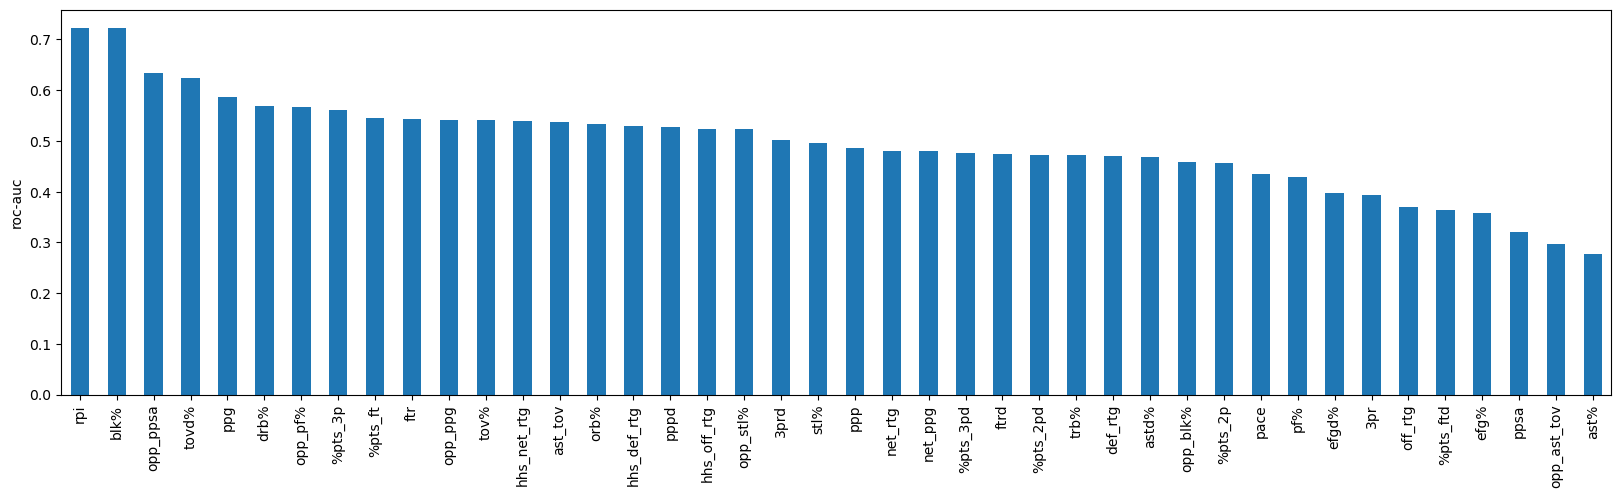

In [25]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [26]:
len(roc_values[roc_values > 0.5])

20

In [27]:
len(roc_values[roc_values > 0.6])

4

In [39]:
roc_values[roc_values > 0.5]

ppg           0.5866
opp_ppg       0.5411
hhs_net_rtg   0.5390
hhs_off_rtg   0.5238
hhs_def_rtg   0.5303
rpi           0.7229
ftr           0.5433
%pts_ft       0.5455
%pts_3p       0.5606
orb%          0.5325
drb%          0.5693
tov%          0.5411
ast_tov       0.5368
blk%          0.7229
pppd          0.5281
opp_ppsa      0.6342
3prd          0.5022
tovd%         0.6234
opp_stl%      0.5238
opp_pf%       0.5671
dtype: float64

### IV. Exhaustive Feature Selection

In [40]:
X_train_scaled2 = X_train_scaled[[
 'rpi',
 'net_ppg',
 'net_rtg',
 'drb%',
 'opp_pf%',
 'hhs_net_rtg',
 'tov%',
 'stl%',
 'blk%',
 '%pts_ftd',
 'orb%',
 'trb%',
 'ast%',
 'hhs_def_rtg',
 'hhs_off_rtg'
]]

X_test_scaled2 = X_test_scaled[[
 'rpi',
 'net_ppg',
 'net_rtg',
 'drb%',
 'opp_pf%',
 'hhs_net_rtg',
 'tov%',
 'stl%',
 'blk%',
 '%pts_ftd',
 'orb%',
 'trb%',
 'ast%',
 'hhs_def_rtg',
 'hhs_off_rtg'
]]

In [41]:
# Initialize variables to track the best model
log_reg = LogisticRegression(solver='liblinear')
best_f1 = 0
best_features = []
best_train_f1 = 0

# Iterate over all possible subsets of features
for k in range(1, len(X_train_scaled2.columns) + 1):
    for subset in combinations(X_train_scaled2.columns, k):
        X_train_subset = X_train_scaled2[list(subset)]
        X_test_subset = X_test_scaled2[list(subset)]
        
        # Train the model with the subset of features
        log_reg.fit(X_train_subset, y_train)
        
        # Make predictions on the test set
        y_test_pred = log_reg.predict(X_test_subset)
        test_f1 = f1_score(y_test, y_test_pred)
        
        # Make predictions on the training set
        y_train_pred = log_reg.predict(X_train_subset)
        train_f1 = f1_score(y_train, y_train_pred)
        
        # Track the best subset based on test F1 score
        if test_f1 > best_f1:
            best_f1 = test_f1
            best_features = subset
            best_train_f1 = train_f1

# Output the best feature subset and the F1 scores
print(f"Best Feature Subset: {best_features}")
print(f"Best Test F1 Score: {best_f1:.4f}")
print(f"Training F1 Score of Best Model: {best_train_f1:.4f}")

Best Feature Subset: ('rpi', 'drb%', 'blk%', '%pts_ftd')
Best Test F1 Score: 0.9333
Training F1 Score of Best Model: 0.8713


### V. XG Boost

In [42]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400, 500, 1000],
    'subsample': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'gamma': [0.2, 0.3, 0.4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train_scaled2, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Hyperparameters: {'colsample_bytree': 0.4, 'gamma': 0.4, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.4}


In [43]:
# Retrain the model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    **best_params
)

best_xgb_model.fit(X_train_scaled2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [44]:
# Predict probabilities
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled2)[:, 1]

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss on test set: {logloss}")

Log Loss on test set: 0.5717270727063293


In [45]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train_scaled2)
y_test_pred = best_xgb_model.predict(X_test_scaled2)

# Calculate accuracy scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {f1_train:.2f}")
print(f"F1 Score on Test Data: {f1_test:.2f}")

F1 Score on Training Data: 0.97
F1 Score on Test Data: 0.81


<Figure size 1000x600 with 0 Axes>

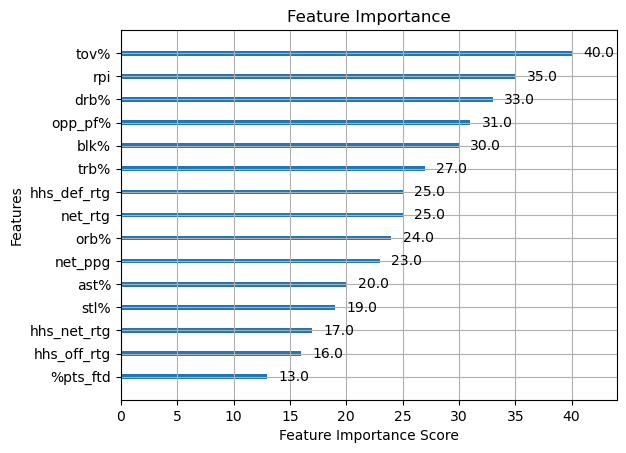

Feature importance (sorted):


NameError: name 'feature_names' is not defined

In [46]:
from xgboost import plot_importance

# Extract feature importance
feature_importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# Visualize feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='weight', show_values=True, xlabel='Feature Importance Score')
plt.title('Feature Importance')
plt.show()

# Print sorted feature importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print("Feature importance (sorted):")
for feature, importance in sorted_importance:
    print(f"{feature_names[int(feature[1:])]}: {importance}")